In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

!ln -s /content/gdrive/ /mydrive

Mounted at /content/gdrive


# Using a Pretrained VGG16 to classify retinal damage from OCT Scans

## Motivation and Context

[Transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) turns out to be useful when dealing with relatively small datasets; for examples medical images, which are harder to obtain in large numbers than other datasets. 
Instead of training a deep neural network from scratch, which would require a significant amount of data, power and time, it's often convenient to use a pretrained model and just finetune its performance to simplify and speed up the process.

*If you are new to convolutional neural networks (CNNs) be sure to check out the [wikipedia page on CNNs](https://en.wikipedia.org/wiki/Convolutional_neural_network) for a more detailed description*

In short, convolutional networks are used on (but not only)  images instead of fully-connected feedforward networks because they would require a very high number of neurons - i.e. at least one per pixel in the input layer - and that would make them inconvenient.

CNNs solve this problem by using a different architecture, summarized in Figure 1

![**Figure 1:** CNN architecture](https://it.mathworks.com/content/mathworks/it/it/discovery/convolutional-neural-network/_jcr_content/mainParsys/image_copy.adapt.full.high.jpg/1523891801700.jpg)

**Figure 1:** CNN architecture (from https://it.mathworks.com/discovery/convolutional-neural-network.html) 

We can identify two main blocks inside of a typical CNN: 
 - Feature extraction
 - Classification
 
The feature extraction is made of a series of convolutional and pooling layers which extract features from the image, increasing in complexity in each layer (i.e. from simpler features in the first layers as points, to more complex ones in the last layers like edges and shapes; see more at [Link #1](http://cs231n.github.io/understanding-cnn) and [Link #2](https://github.com/utkuozbulak/pytorch-cnn-visualizations)).

These features are then fed to a fully connected network (classifier), which learns to classify them.

*Read more about CNNs at http://cs231n.github.io/convolutional-networks/*

So, what we'll do here is using a model (VGG-16)  which is already capable of extracting features from an image and train its fully connected network in order to classify different types of retinal damage instead of objects.

The model we'll use is a [VGG-16](https://www.quora.com/What-is-the-VGG-neural-network)- convolutional network, trained on [ImageNet](http://www.image-net.org/) dataset. 

This work will use [PyTorch](https://pytorch.org/) as deep learning framework and [CUDA](https://developer.nvidia.com/cuda-zone) for GPU acceleration. 

## Implementation

*Python Modules*

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


## Dataset loader

The dataset is divided in three categories: training, validation and test. 

The first one will be, obviously, used for trainig; the validation set will be used to measure the model performance during training and the test set will be used to evaluate our model performance once the training has finished.

*Note:* These three sets should all contain different images.

Loading this dataset with pytorch is really easy using [ImageFolder](https://pytorch.org/docs/master/torchvision/datasets.html#imagefolder) as the labels are specified by the folders names.  

In [6]:
data_dir = '/content/gdrive/MyDrive/Dataset/COVID-19_PN_Dataset/full'

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225] )
    ])

In [7]:
import torchvision
from torchvision.transforms import ToTensor

full_data = torchvision.datasets.ImageFolder(data_dir, transform=TRANSFORM_IMG)
train_data, test_data, valid_data = torch.utils.data.random_split(full_data, [1985, 248, 248])

print("Classes: ")
class_names = full_data.classes
print(full_data.classes)

Classes: 
['COVID', 'non-COVID']


In [8]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

batch_size = 16

train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader  = data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 

## Utils

Some utility function to visualize the dataset and the model's predictions

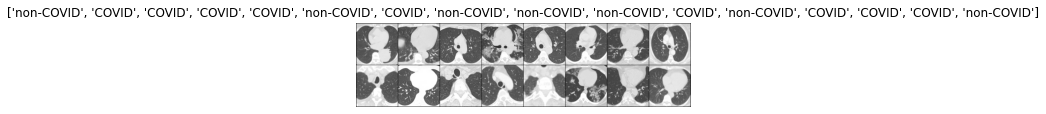

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(train_loader))
show_databatch(inputs, classes)

In [10]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(test_loader):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

This helper function will give us the accuracy of our model on the test set.

In [11]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(test_loader)
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(test_loader):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / len(test_data)
    avg_acc = acc_test / len(test_data)
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

## Model creation

The [VGG-16](https://www.quora.com/What-is-the-VGG-neural-network) is able to classify 1000 different labels; we just need 4 instead. 
In order to do that we are going replace the last fully connected layer of the model with a new one with 4 output features instead of 1000. 

In PyTorch, we can access the VGG-16 classifier with `model.classifier`, which is an 6-layer array. We will replace the last entry.

We can also disable training for the convolutional layers setting `requre_grad = False`, as we will only train the fully connected classifier.

In [12]:
# Load the pretrained model from pytorch  # bn = batch normalization
vgg16 = models.vgg16_bn() 
vgg16.load_state_dict(torch.load("/content/gdrive/MyDrive/models/vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

The output above is the summary of our model. Notice how the last layer has 4 output features as we specified. 

In [13]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina.pt'))
    print("Loaded!")

We will also define our loss function (cross entropy) and the optimizer. 

The learning rate will start at 0.001 and a StepLR object will decrese it by a factor of 0.1 every 7 epochs (not really needed here as we're training for 2 epochs only)

For further details refer to https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


In [14]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Model evaluation and visualization (before training)

Let's see how our model performs before any training

In [15]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 0/16

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Evaluation completed in 2m 28s
Avg loss (test): 0.0448
Avg acc (test): 0.4637
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Ground truth:


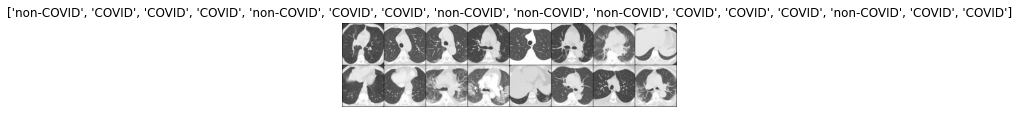

Prediction:


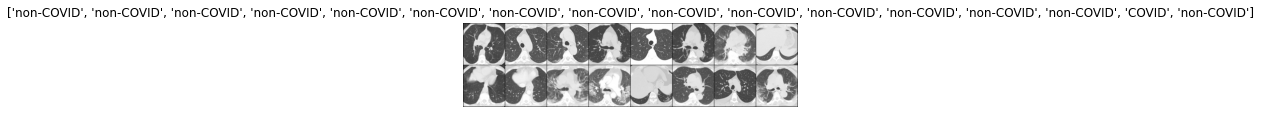

In [16]:
visualize_model(vgg16) #test before training

Not really great results. Let's see if it can do better after training 

## Training

What follows is [pretty standard pytorch code for training](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). 

For every epoch we iterate over all the training batches, compute the loss , and adjust the network weights with `loss.backward()` and `optimizer.step()`. 
Then we evaluate the performance over the validaton set. At the end of every epoch we print the network progress (loss and accuracy). 
The accuracy will tell us how many predictions were correct.

As we said before, transfer learning can work on smaller dataset too, so for every epoch we only iterate over half the trainig dataset (worth noting that it won't exactly be half of it over the entire training, as the data is shuffled, but it will almost certainly be a subset) 

In [22]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(train_loader)
    val_batches = len(valid_loader)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(train_loader):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / len(train_data)
        avg_acc = acc_train * 2 / len(train_data)
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(valid_loader):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / len(valid_data)
        avg_acc_val = acc_val / len(valid_data)
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [23]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(vgg16.state_dict(), 'VGG16_v2-COVID-19_Dataset.pt')

Epoch 0/10
----------
Training batch 0/62.5
Validation batch 0/16

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Epoch 0 result: 
Avg loss (train): 0.0254
Avg acc (train): 0.8252
Avg loss (val): 0.0177
Avg acc (val): 0.8871
----------

Epoch 1/10
----------
Training batch 0/62.5
Validation batch 0/16
Epoch 1 result: 
Avg loss (train): 0.0108
Avg acc (train): 0.9491
Avg loss (val): 0.0136
Avg acc (val): 0.9274
----------

Epoch 2/10
----------
Training batch 0/62.5
Validation batch 0/16
Epoch 2 result: 
Avg loss (train): 0.0059
Avg acc (train): 0.9804
Avg loss (val): 0.0075
Avg acc (val): 0.9556
----------

Epoch 3/10
----------
Training batch 0/62.5
Validation batch 0/16
Epoch 3 result: 
Avg loss (train): 0.0047
Avg acc (train): 0.9914
Avg loss (val): 0.0042
Avg acc (val): 0.9718
----------

Epoch 4/10
----------
Training batch 0/62.5
Validation batch 0/16
Epoch 4 result: 
Avg loss (train): 0.0024
Avg acc (train): 0.9995
Avg loss (val): 0.0036
Avg acc (val): 0.9758
----------

Epoch 5/10
----------
Training batch 0/62.5
Validation batch 0/16
Epoch 5 result: 
Avg loss (train): 0.0031
Avg acc (tra

## Model evaluation and visualization (after training)

Let's evaluate our model again after 2 epochs of training

In [24]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 0/16

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Evaluation completed in 0m 5s
Avg loss (test): 0.0052
Avg acc (test): 0.9758
----------


Now that's a pretty good result!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Ground truth:


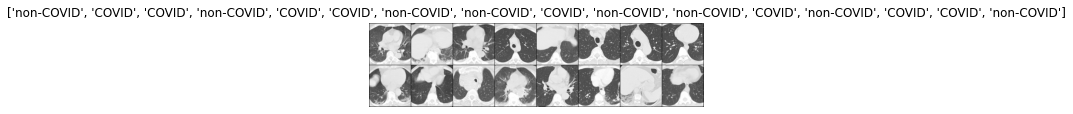

Prediction:


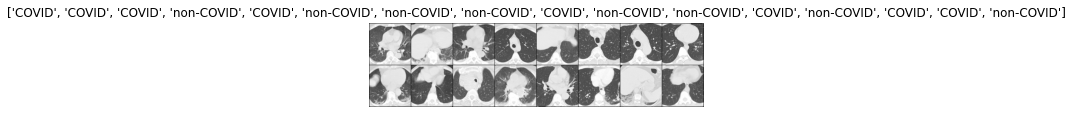

Ground truth:


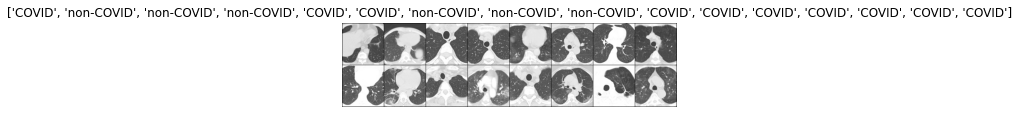

Prediction:


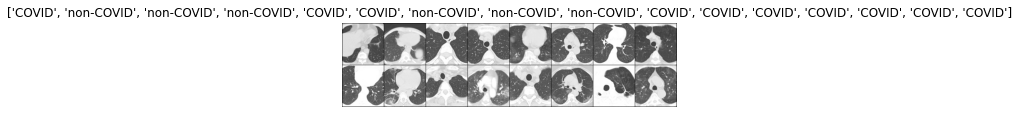

In [25]:
visualize_model(vgg16, num_images=32)

#  Taken from ConVit Notebook

In [91]:
from tqdm.notebook import tqdm
device = 'cuda'

y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = vgg16(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/16 [00:00<?, ?it/s]

In [92]:
def flatten(new:list, target:list):
    for li in target:
        for value in list(li):
            new.append(value)

y_pred = []
y_true = []
flatten(y_pred, y_pred_list)
flatten(y_true, y_true_list)

In [93]:
from sklearn.metrics import accuracy_score, f1_score
print("Overall accuracy:", accuracy_score(y_true, y_pred))
print("Overall F1:", f1_score(y_true, y_pred, average='weighted'))

Overall accuracy: 0.9758064516129032
Overall F1: 0.9758064516129032


In [94]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.97692308 0.97457627]
recall: [0.97692308 0.97457627]
fscore: [0.97692308 0.97457627]
support: [130 118]


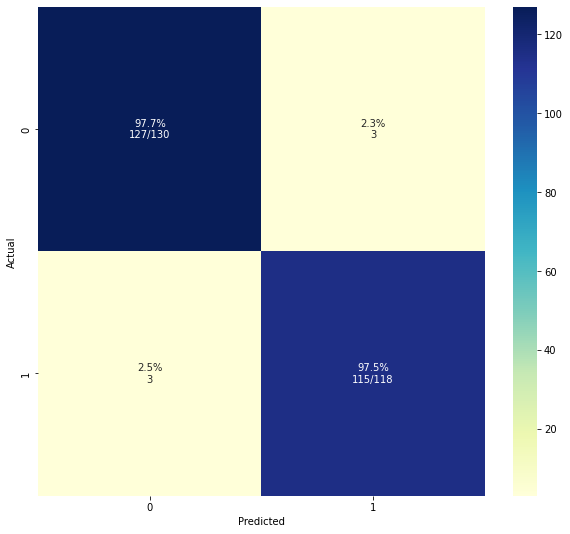

In [95]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

def plot_cm(y_true, y_pred, figsize=(10,9)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

plot_cm(y_true, y_pred)

display()

In [96]:
def predict_image(image):
    image_tensor = TRANSFORM_IMG(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = vgg16(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [97]:
classes = ['Positive', 'Negative']
def get_random_images(num):
    # classes = test_data.classes
    indices = list(range(len(test_data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(test_data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

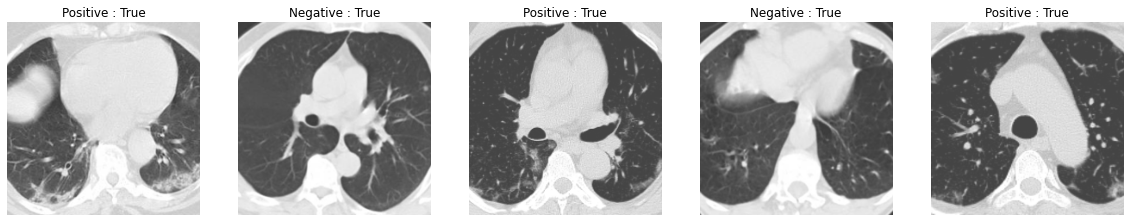

In [98]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + " : " + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

# Grad-CAM Visualizations

In [27]:
class Flatten(nn.Module):
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

In [28]:
features_fn = nn.Sequential(*list(vgg16.features.children())[:-1])
classifier_fn = nn.Sequential(*(list(vgg16.features.children())[-1:] + [Flatten()] + list(vgg16.classifier.children())))

In [29]:
vgg16 = vgg16.eval()
vgg16 = vgg16.cuda()

In [30]:
def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda())
    _, N, H, W = feats.size()
    out = classifier_fn(feats)
    c_score = out[0, c]
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal

In [50]:
from PIL import Image

# Opens image from disk, normalizes it and converts to tensor
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    lambda x: torch.unsqueeze(x, 0)
])

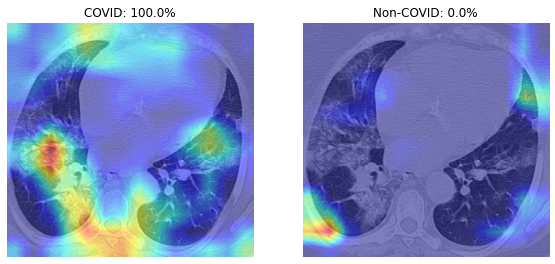

In [66]:
img_path = '/content/gdrive/MyDrive/Dataset/COVID-19_PN_Dataset/full/COVID/Covid (1000).png'
img_tensor = read_tensor(img_path)
pp, cc = torch.topk(nn.Softmax(dim=1)(vgg16(img_tensor.cuda())), 2)

plt.figure(figsize=(15, 5))
for i, (p, c) in enumerate(zip(pp[0], cc[0])):
    plt.subplot(1, 3, i+1)
    sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
    img = Image.open(img_path)
    sal = Image.fromarray(sal)
    sal = sal.resize(img.size, resample=Image.LINEAR)
    
    cw = "COVID" if c == 0 else "Non-COVID"

    plt.title('{}: {:.1f}%'.format(cw, 100*float(p)))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(np.array(sal), alpha=0.5, cmap='jet')

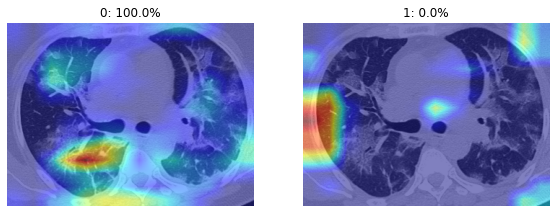

In [68]:
img_path = '/content/gdrive/MyDrive/Dataset/COVID-19_PN_Dataset/full/COVID/Covid (2).png'
img_tensor = read_tensor(img_path)
pp, cc = torch.topk(nn.Softmax(dim=1)(vgg16(img_tensor.cuda())), 2)

plt.figure(figsize=(15, 5))
for i, (p, c) in enumerate(zip(pp[0], cc[0])):
    plt.subplot(1, 3, i+1)
    sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
    img = Image.open(img_path)
    sal = Image.fromarray(sal)
    sal = sal.resize(img.size, resample=Image.LINEAR)

    plt.title('{}: {:.1f}%'.format(c, 100*float(p)))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(np.array(sal), alpha=0.5, cmap='jet')

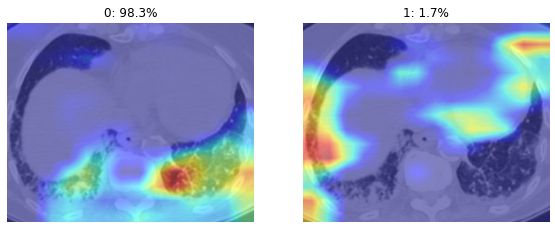

In [69]:
img_path = '/content/gdrive/MyDrive/Dataset/COVID-19_PN_Dataset/full/COVID/Covid (599).png'
img_tensor = read_tensor(img_path)
pp, cc = torch.topk(nn.Softmax(dim=1)(vgg16(img_tensor.cuda())), 2)

plt.figure(figsize=(15, 5))
for i, (p, c) in enumerate(zip(pp[0], cc[0])):
    plt.subplot(1, 3, i+1)
    sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
    img = Image.open(img_path)
    sal = Image.fromarray(sal)
    sal = sal.resize(img.size, resample=Image.LINEAR)

    plt.title('{}: {:.1f}%'.format(c, 100*float(p)))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(np.array(sal), alpha=0.5, cmap='jet')
plt.show()

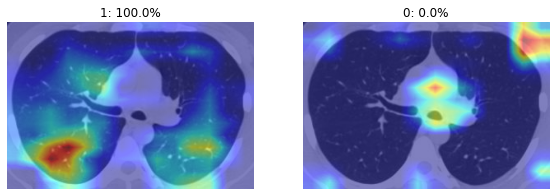

In [70]:
img_path = '/content/gdrive/MyDrive/Dataset/COVID-19_PN_Dataset/full/non-COVID/Non-Covid (200).png'
img_tensor = read_tensor(img_path)
pp, cc = torch.topk(nn.Softmax(dim=1)(vgg16(img_tensor.cuda())), 2)

plt.figure(figsize=(15, 5))
for i, (p, c) in enumerate(zip(pp[0], cc[0])):
    plt.subplot(1, 3, i+1)
    sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
    img = Image.open(img_path)
    sal = Image.fromarray(sal)
    sal = sal.resize(img.size, resample=Image.LINEAR)

    plt.title('{}: {:.1f}%'.format(c, 100*float(p)))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(np.array(sal), alpha=0.5, cmap='jet')
plt.show()